# Goals

- Understand the precess of an OCR problems
- Implement printed text images using python and its libraries

# Flow

- Input Image Preprocessing:
    + Paragraphs extracting
    + Lines in paragraph extracting
- OCR for each lines by Deep Learning CRNN-CTC
- Post-processing and output

# Section 1: Input Image Preprocessing

In [1]:
cd Main

/home/rnd/haidx/project1/Main


In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image, ImageFont, ImageDraw
import tensorflow as tf
import os, json, shutil, re

%load_ext autoreload
%autoreload 2

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
# reset output data
output_folder = 'output/'
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
os.makedirs(os.path.join(output_folder + 'lines'))
os.makedirs(os.path.join(output_folder + 'para'))

## Paragraph Segmentation

**Load and show input image**

In [5]:
ori_image = cv2.imread('samples/dacnhantam2.PNG')

In [6]:
def show_images(*images, size=10):
    import matplotlib.pyplot as plt
    fig=plt.figure(figsize=(size, size))
    
    for i, img in enumerate(images):
        if len(img.shape) < 3:
            plt.subplot(int("1"+str(len(images))+str(i+1))),plt.imshow(img, cmap=plt.cm.gray)
        else:
            plt.subplot(int("1"+str(len(images))+str(i+1))),plt.imshow(img)
    plt.show()
    
def save_images(*images, prefix_name='', extension = '.jpg', folder_path='.'):
    try:
        for i, img in enumerate(images):
            file_name = prefix_name + str(i) + extension
            cv2.imwrite(folder_path + '/' + file_name, img)
    except:
        print('Oops, something wrong with the input images or folder_path is not exist.')

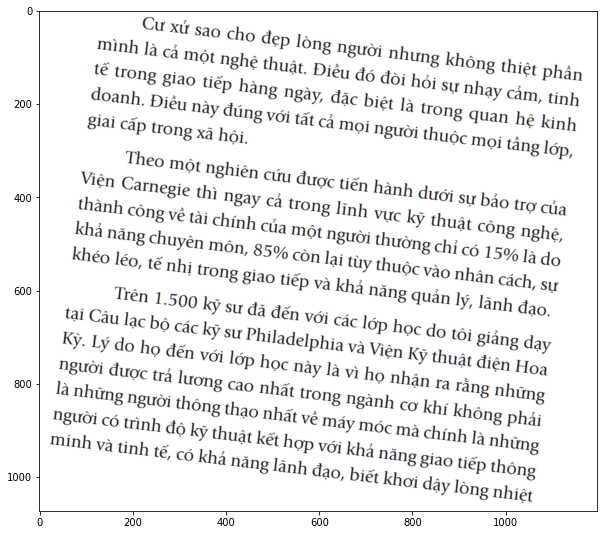

In [7]:
show_images(ori_image, size=10)

### Find paragraph contours

**Convert to binary image and denoises**

In [8]:
def denoise_binary_converter(image, blur = True):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if blur:
        gray = cv2.GaussianBlur(gray, (7,7), 0)
    # thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                cv2.THRESH_BINARY_INV,5,2)

    thresh = cv2.fastNlMeansDenoising(thresh, thresh, 50, 7, 21)
    _, thresh = cv2.threshold(thresh, 200, 255, cv2.THRESH_BINARY)

    return thresh

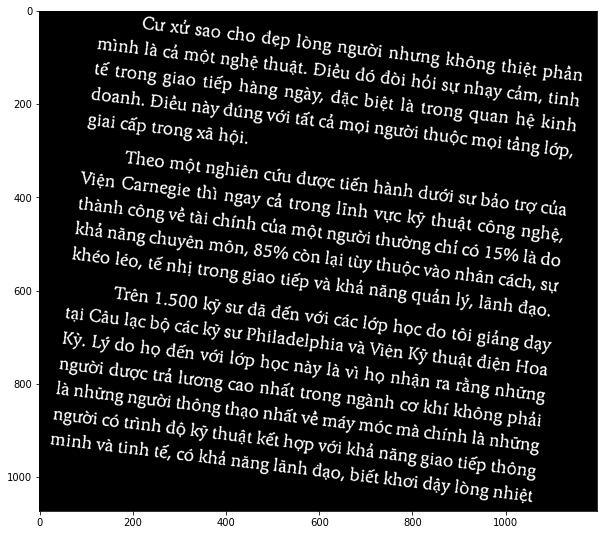

In [9]:
img = ori_image.copy()

threshed_img = denoise_binary_converter(img, blur=True)
show_images(threshed_img, size=10)

**Dilation and fine contours**

In [10]:
def find_paragraph_contours(binary_image, return_dilate=False):
    # Create rectangular structuring element and dilate
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
    dilate = cv2.dilate(binary_image, kernel, iterations=4)

    # Find contours and draw rectangle
    cnts, hierarchy = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if return_dilate:
        return cnts, hierarchy, dilate
    else:
        return cnts, hierarchy

def sort_contours(cnts, method="top-to-bottom"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "left-to-right":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

def draw_contours_bounding_box(image, contours, color=(0,255,0)):
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        
def contour_rotated_box(image, contours, color = (0,255,0), draw=True):
    """Draw the align-rotated bounding box for contours on image
    return contour box list (coordinates)
    """
    contour_box_list = []
    for contour in contours:
        rbox = cv2.minAreaRect(contour)
        pts = cv2.boxPoints(rbox)
        pts = np.intp(pts)
        contour_box_list.append(pts)
        if draw:
            cv2.drawContours(image, [pts], -1, color, 1, cv2.LINE_AA)
    return contour_box_list

In [11]:
cnts, hierarchy, dilate = find_paragraph_contours(threshed_img, return_dilate=True)

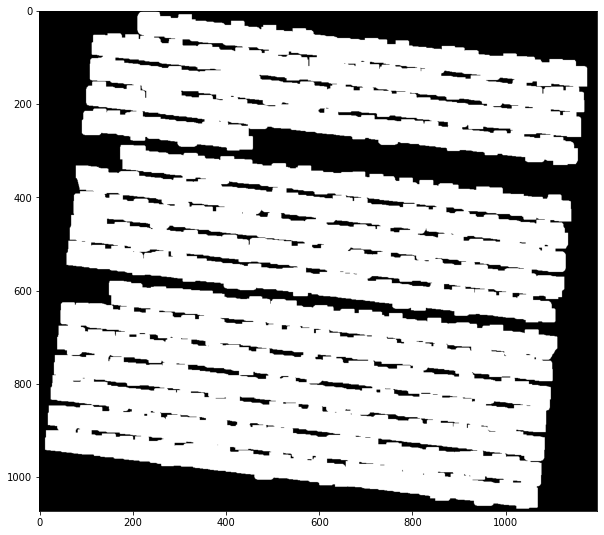

In [12]:
show_images(dilate)

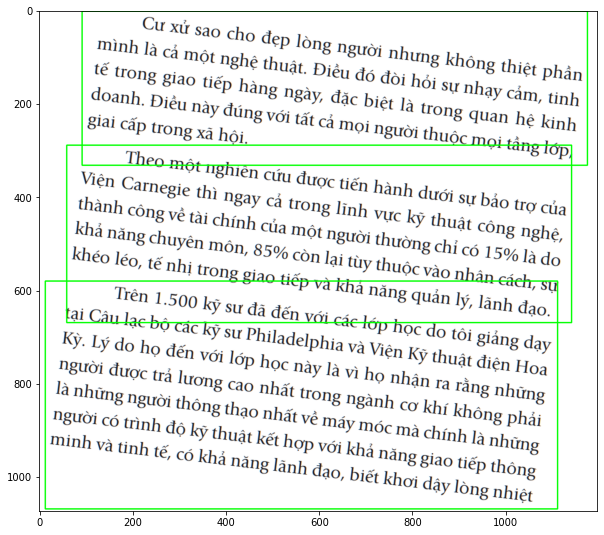

In [13]:
draw_contours_bounding_box(img, cnts)
show_images(img)

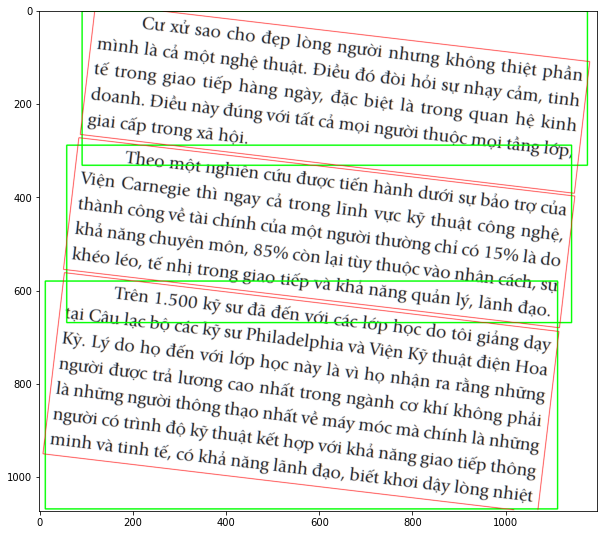

In [14]:
para_boxes = contour_rotated_box(img, cnts, color=(255,0,0), draw=True) # red boxes
show_images(img)

In [15]:
para_boxes

[array([[1069, 1076],
        [   8,  950],
        [  54,  562],
        [1115,  688]]),
 array([[1116,  680],
        [  52,  555],
        [  85,  273],
        [1149,  398]]),
 array([[1148,  392],
        [  88,  266],
        [ 121,  -15],
        [1181,  110]])]

### Paragraph Aligment

Using Perspective Transform Algorithm

In [16]:
def order_points(pts):
    """return ordered coordinates of 4 points of a rectangle box in clock-wise, that:
    rect[0]: top-left
    rect[1]: top-right
    rect[2]: bottom-right
    rect[3]: bottom-left
    """
    rect = np.zeros((4, 2), dtype = "float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect

def object_extraction(sence_image, object_points, inter=cv2.INTER_NEAREST):
    """Extract and align object in image
    Input: image contains object, 4 points of object conner
    Output: image of object only
    """

    pts1 = order_points(object_points)
    h = int(np.linalg.norm(pts1[0]-pts1[3]))
    w = int(np.linalg.norm(pts1[0]-pts1[1]))

    pts2 = np.float32([[0,0],[w,0],[w,h],[0,h]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    dst = cv2.warpPerspective(sence_image,M,(w, h), inter)

    return dst

def paragraph_box_extracting(binary_image):
    """Extract paragraph regions from text image
    input: binary image
    output: list of paragraph region coordinates: [origin_x, origin_y, w, h]
    """
    paragraph_cnts, _ = find_paragraph_contours(binary_image)
    paragraph_cnts, _ = sort_contours(paragraph_cnts, method="top-to-bottom")
    
    para_boxes = contour_rotated_box(binary_image, paragraph_cnts, color=(255,0,0), draw=False) # red boxes
    para_boxes_sorted = []
    for box in para_boxes:    
        points = order_points(box)
        para_boxes_sorted.append(points)
        
    return para_boxes_sorted

def paragraph_extracting(image):
    """
    input: text page image
    output: image of paragraphs extracted from input image
    """
    para_images = []
    binary_image = denoise_binary_converter(image, blur=True)
    
    paragraph_cnts, _ = find_paragraph_contours(binary_image)
    paragraph_cnts, _ = sort_contours(paragraph_cnts, method="top-to-bottom")
    
    para_boxes = contour_rotated_box(binary_image, paragraph_cnts, color=(255,0,0), draw=False) # red boxes

    for box in para_boxes:
        box_sorted = order_points(box)
        para_image = object_extraction(img, box)
        para_images.append(para_image)
    
    return para_images

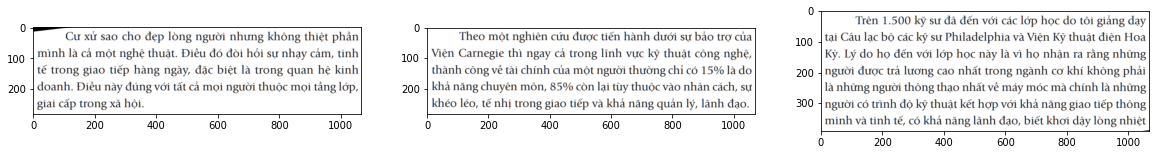

In [17]:
img = ori_image.copy()

para_images = paragraph_extracting(img)

show_images(*para_images, size = 20)

In [18]:
save_images(*para_images, prefix_name='para_', folder_path='output/para')

In [19]:
para_images[0].shape

(282, 1067, 3)

## Line Segmentating

In [20]:
def line_segmentating(single_paragraph_image, draw=False, return_dilate=False):
    """
    Extract lines from paragraph image
    Input: Single paragraph image
    Output: list of line images (list of numpy array) ordered top-to-bottom
    """
    image = single_paragraph_image.copy()
    thresh = denoise_binary_converter(image, blur=True)

    # dilation for line
    kernel = np.ones((2, 50), np.uint8) # the kernel mainly expand in horizontal axis
    img_dilation = cv2.dilate(thresh, kernel, iterations=1)

    #find contours
    ctrs, hier = cv2.findContours(img_dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #sort contours
    # sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
    sorted_contours, _ = sort_contours(ctrs, method="top-to-bottom")
    
    lines = contour_rotated_box(single_paragraph_image, sorted_contours, draw=draw, color=(255,0,0))
    
    line_rois = []
    for line in lines:
        line_rois.append(object_extraction(image, line))
        
    output = line_rois
    
    if return_dilate:
        output = line_rois, img_dilation
    
    return output

def line_extractor_ulti(page_image):
    """
    Extract line images from page image
    Input: page image
    Output: dictionary of lines of each paragraph in input page image
    """
    para_images = paragraph_extracting(page_image)
    line_image_dict = {}
    for i, para in enumerate(para_images):
        para_name = 'para_' + str(i)
        lines = line_segmentating(para, draw=False)
        line_image_dict[para_name] = lines
        
    return line_image_dict    

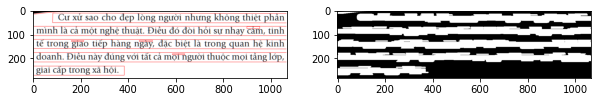

In [21]:
lines, dilated = line_segmentating(para_images[0], draw=True, return_dilate=True)
show_images(para_images[0], dilated)

In [22]:
line_image_dict = line_extractor_ulti(img)

In [23]:
line_image_dict['para_0'][0].shape

(10, 149, 3)

In [24]:
# save line images
for para_name, line_list in line_image_dict.items():
    save_images(*line_list, prefix_name=para_name + '_line_', folder_path='output/lines')

### Conclusion

- This precedure extremely depends on image condition, such as brightless, contrass between text and background, noises, size of input image...
- So, for each type of ocr problems, we must build a more general extractor, or fine tune the parametter for that problem.
- After this section, we got a dictionary of lines in each paragraph of input images:

``
{
    'para_0': [list of numpy array line images],
    ...
    'para_i': [list of numpy array line images],
    ...
}
``

# Section 2: OCR models

- In this section, we'll build a model which take a text line image as input and return the according raw string that it has recognized

- Model: CRNN + CTC loss
    + CNN: **Convolutional Neural Network** for features extracting
    + RNN: **Bi-directional GRU** (recurrent architect) for decoding these features in to string of characters
    + CTC: **Connectionist Temporal Classification** for predict the real text from previous string

- Evaluation: **Edit distance**
    + Compare 2 strings by their similarity
    + The lower Edit distance, the more similar 2 strings is

## Building CRNN-CTC model

<img src="images/crnn-2.png" style="width: 500px;"/>

## Pre-trained model

In [25]:
import torch
from torch.autograd import Variable
from src.utils import strLabelConverter, resizePadding
from PIL import Image
import sys
import src.crnn as crnn
import argparse
from torch.nn.functional import softmax
import numpy as np
import time

ALPHABET = open('lib/char', encoding='utf8').read().rstrip()

In [26]:
torch.__version__

'1.5.1+cu101'

In [27]:
torch.cuda.is_available()

True

In [28]:
nclass = len(ALPHABET) + 1
nc = 3
imgH = 32

model_path = 'models/CRNN_CTC_1.pth'
model = crnn.CRNN(imgH, nc, nclass, 256)
if torch.cuda.is_available():
    model = model.cuda()
print('loading CRNN-CTC model from %s' % model_path)
model.load_state_dict(torch.load(model_path, map_location='cpu'))

loading CRNN-CTC model from models/CRNN_CTC_1.pth


<All keys matched successfully>

In [29]:
from torchsummary import summary
imgH=32
imgW=1100 # samples with smaller width will be postly padded
summary(model.cnn, (3, 32, 1100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 32, 1100]           1,792
       BatchNorm2d-2         [-1, 64, 32, 1100]             128
              ReLU-3         [-1, 64, 32, 1100]               0
         MaxPool2d-4          [-1, 64, 16, 550]               0
            Conv2d-5         [-1, 128, 16, 550]          73,856
       BatchNorm2d-6         [-1, 128, 16, 550]             256
              ReLU-7         [-1, 128, 16, 550]               0
         MaxPool2d-8          [-1, 128, 8, 275]               0
            Conv2d-9          [-1, 256, 8, 275]         295,168
      BatchNorm2d-10          [-1, 256, 8, 275]             512
             ReLU-11          [-1, 256, 8, 275]               0
           Conv2d-12          [-1, 256, 8, 275]         590,080
      BatchNorm2d-13          [-1, 256, 8, 275]             512
             ReLU-14          [-1, 256,

In [30]:
def predict(image, model, output_path=None, imgW=None, imgH=32, verbose=False):
    """
    Input: line image (PIL image object)
    Output: predicted text and its probability
    if output_folder is not None, save .txt file to that folder
    ------
    **Parameters**:
    - img_path: path to color image to be predicted
    - model: model which will be used for prediction
    - output_path: the folder in which output .txt file will save
    - imgW: the width of input image. If None, it'll be calculated autotically
    - imgH: the height of input image. Default=32.
    - return_raw: return raw string
    """
    if verbose:
        start_time = time.time()
        
    converter = strLabelConverter(ALPHABET, ignore_case=False)
    
    if type(image).__module__ == np.__name__: # if numpy array, convert to PIL image instance
        image = Image.fromarray(image)
    
    image = image.convert('RGB')
    image = resizePadding(image, imgW, imgH)

    if torch.cuda.is_available():
        image = image.cuda()

    image = image.view(1, *image.size())
    image = Variable(image)

    model.eval()

    start_time = time.time()
    preds = model(image)

    values, prob = softmax(preds, dim=-1).max(2)
    preds_idx = (prob > 0).nonzero()
    sent_prob = values[preds_idx[:,0], preds_idx[:, 1]].mean().item()

    _, preds = preds.max(2)
    preds = preds.transpose(1, 0).contiguous().view(-1)
    preds_size = Variable(torch.IntTensor([preds.size(0)]))
    raw_pred = converter.decode(preds.data, preds_size.data, raw=True)
    sim_pred = converter.decode(preds.data, preds_size.data, raw=False)
    
    if verbose:
        print('%-20s => %-20s : prob: %s time: %s' % (raw_pred, sim_pred, sent_prob, 
                                                      time.time() - start_time))
    if output_path is not None: # export .txt file
        image_file_name = os.path.split(img_path)[1] # os.path.split return (folder_path, filename)
        text_file_path = os.path.join(output_path, image_file_name[:-4] + '.txt')
        with open(text_file_path, 'w', encoding='utf8') as f: # output_path/image_name.txt
            f.write(sim_pred)
    
    return sim_pred

def predict_batch(image_list, model , output_file_path=None,  imgW=None, imgH=32):
    """
    Predict on batch of lines
    Input: list of line images
    Output: list of text lines
    ------
    Parameters:
    - line_image_list: list of line images (3D numpy array)
    - output_name: the file.txt in which output will be saved (all texts)
    - imgW: the width of input image. If None, it'll be calculated autotically
    - imgH: the height of input image. Default=32.
    """
    predict_func = lambda img:predict(img, model)
    text_list = list(map(predict_func, image_list))
    
    if output_file_path is not None:
        with open(output_file_path, 'w', encoding='utf8') as f:
            for line in text_list:
                f.write(line + '\n')
    
    return text_list

def predict_ulti(line_image_dict, output_file_path=None,  imgW=None, imgH=32, model_path='models/CRNN_CTC_1.pth'):
    """
    Predict text for full page image
    Input: line image dictionary taken from image processing section
    Output: text dictionary
    ------
    Parameters:
    - line_image_list: line image dict which contain list of line images (3D numpy array) for each key (paragraph)
    - output_name: the file.txt in which output will be saved (all texts)
    - imgW: the width of input image. If None, it'll be calculated autotically
    - imgH: the height of input image. Default=32.
    - model_path: path to CRNN-CTC model
    """
    nclass = len(ALPHABET) + 1
    nc = 3
    
    model = crnn.CRNN(imgH, nc, nclass, 256)
    if torch.cuda.is_available():
        model = model.cuda()
    print('loading CRNN-CTC model from %s' % model_path)
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    
    line_text_dict = {}
    for para, image_list in line_image_dict.items():
        text_list = predict_batch(image_list, model , output_file_path=None,  imgW=None, imgH=imgH)
        line_text_dict[para] = text_list
        
    if output_file_path is not None:
        with open(output_file_path, 'w', encoding='utf8') as f:
            for para, text_list in line_text_dict.items():
                for line in text_list:
                    f.write(line + '\n')
                f.write('\n')
    
    return line_text_dict

In [31]:
tic = time.time()
image = Image.open('output/lines/para_0_line_0.jpg') # ensure that image.shape=(w, h, 3)
print(predict(image, model))
time.time()-tic

0.013869285583496094

In [32]:
file_path_list = [os.path.join('output/lines/', file) for file in os.listdir('output/lines') if file[-4:]=='.jpg' and file[5]=='0']
file_path_list.sort(key=lambda f: int(re.sub('\D', '', f))) # sort file names
images = []
for file_path in file_path_list:
    image = Image.open(file_path).convert('RGB')
    images.append(image)

In [33]:
# convert to binary images
# binary_images = list(map(lambda img:255 - denoise_binary_converter(np.array(img), blur=False), images))

In [34]:
# show_images(binary_images[0])

In [35]:
tic = time.time()
texts = predict_batch(images, model, output_file_path='output/output.txt')
print(time.time() - tic)
texts

0.10960626602172852


['',
 'cư xử sao cho đp lòng người nhưng không thiệt phẩn',
 'T',
 'mình lhà cả một nghệ thuật. điều đố đời hối sự nhạy cẩm, tinh',
 'tê trong giao tiếp hàng ngày, đặc biệt là trong quan hệ kinh',
 '',
 'i',
 'doanh. điều mày đáng với tất cả mợi người thuộc mợi tầng lứp',
 'Hi',
 'giai cấp trong xã hội.']

In [36]:
tic = time.time()
text_dict = predict_ulti(line_image_dict, output_file_path='output/output.txt')
time.time() - tic

loading CRNN-CTC model from models/CRNN_CTC_1.pth


0.5210068225860596

In [37]:
def show_text_dict(line_text_dict):
    for para, text_list in line_text_dict.items():
        print(*text_list, sep='\n', end='\n\n')

In [38]:
show_text_dict(text_dict)

V    M
cư xử sao cho độp lòng người nhũng không thiệt phần

mình là cả một nghệ thuật. điều đố đời hôi sự nhạy cẩm, tinh
tế trong giao tiếp hàng ngày, đặc biệt là trong quan hệ kinh

i
đoanh. điều mày đáng với tất cả mợi người thuộc mợi tầng lứp
i
giai cấp trong xã hội

Theo mmột nghiên cứu được tiến hành dưới sự bảo trợ của
viện carnhegie thi ngay cả trong lỉnh vục kỹ thuật công nghệ
thành công về tài chính của một người thường chỉ cô 1596 là đo
khả năng chuyên môn, 859% còn lại tủy thuộc vào nhân cách, sự
n
g
khếo lếo, tế nhị trong giao tiếp và khả năng quản lỹ, lãnh đạo
i

Trên 1.500 kỹ sư đấ đền với các lóp học đo tổi giảng dạy
tại Cảu lạc bộ các kỹ sư philadelphia và viện kỹ thuật điện Hoa
g
kỳ. lý do họ đến với lốp học này là vi họ nhận ra rằng những
người được trả lương cao nhất trong ngành cơ khí không phải
là những người thông thạo nhắt về mấy mốc mà chính là những
ải
ải
người có trình độ kỹ thuật kết hợp với khả năng giao tiếp thông
i
minh và tỉnh tế có khả năng lănh đạo, biế

# Improvement

- Improve image processing process
- Language model at output for correction